<a href="https://colab.research.google.com/github/rnarkk/jupyter/blob/main/Bayesian-Methods-for-Hackers/Chapter_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Probabilistic Programming and Bayesian Methods for Hackers Chapter  2

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_TFP.ipynb"><img height="32px" src="https://colab.research.google.com/img/colab_favicon.ico" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_TFP.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>
<br>
<br>
<br>

Original content ([this Jupyter notebook](https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC2.ipynb)) created by Cam Davidson-Pilon ([`@Cmrn_DP`](https://twitter.com/Cmrn_DP))

Welcome to Bayesian Methods for Hackers. The full Github repository is available at [github/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers). The other chapters can be found on the project's [homepage](https://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/). We hope you enjoy the book, and we encourage any contributions!
___

### Table of Contents

- A little more on TFP
  - TFP Variables
    - Initializing Stochastic Variables
    - Deterministic variables
  - Combining with Tensorflow Core
  - Including observations in the Model
- Modeling approaches
  - Same story; different ending
  - Example: Bayesian A/B testing
  - A Simple Case
    - Execute the TF graph to sample from the posterior
  - A and B together
    - Execute the TF graph to sample from the posterior
- An algorithm for human deceit
  - The Binomial Distribution
  - Example: Cheating among students
    - Execute the TF graph to sample from the posterior
  - Alternative TFP Model
    - Execute the TF graph to sample from the posterior
  - More TFP Tricks
  - Example: Challenger Space Shuttle Disaster
    - Normal Distributions
      - Execute the TF graph to sample from the posterior
    - What about the day of the Challenger disaster?
    - Is our model appropriate?
      - Execute the TF graph to sample from the posterior
  - Exercises
  - References
___

This chapter introduces more TFP syntax and variables and ways to think about how to model a system from a Bayesian perspective. It also contains tips and data visualisation techniques for assessing goodness-of-fit for your Bayesian model.

In [ ]:
!pip3 install -U pip
!pip3 uninstall -y tensorflow tensorflow-probability
!pip3 install -U jax tfp-nightly[jax]

!pip3 install -q wget

In [ ]:
"""
The book uses a custom matplotlibrc file, which provides the unique styles for
matplotlib plots. If executing this book, and you wish to use the book's
styling, provided are two options:
    1. Overwrite your own matplotlibrc file with the rc-file provided in the
       book's styles/ dir. See http://matplotlib.org/users/customizing.html
    2. Also in the styles is  bmh_matplotlibrc.json file. This can be used to
       update the styles in only this notebook. Try running the following code:

        import json
        s = json.load(open("../styles/bmh_matplotlibrc.json"))
        matplotlib.rcParams.update(s)
"""
from jax import jit, random
import jax.numpy as np
from jax.numpy import int32 as i32, float32 as f32
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
Bernoulli, Binomial, Deterministic, Exponential, Gamma, Normal, Poisson, Uniform = \
    tfd.Bernoulli, tfd.Binomial, tfd.Deterministic, tfd.Exponential, tfd.Gamma, tfd.Normal, tfd.Poisson, tfd.Uniform
tfb = tfp.bijectors

from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns

import wget

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'

%matplotlib inline

sns.set_context('notebook')

TFColor = [
    '#F15854',
    '#5DA5DA',
    '#FAA43A',
    '#60BD68',
    '#F17CB0',
    '#B2912F',
    '#B276B2',
    '#DECF3F',
    '#4D4D4D']

## A little more on TensorFlow and TensorFlow Probability

To explain TensorFlow Probability, it's worth going into the various methods of working with Tensorflow tensors. Here, we introduce the notion of Tensorflow graphs and how we can use certain coding patterns to make our tensor-processing workflows much faster and more elegant. 

### TensorFlow Graph and Eager Modes

TFP accomplishes most of its heavy lifting via the main `tensorflow` library. The `tensorflow` library also contains many of the familiar computational elements of NumPy and uses similar notation. While NumPy directly executes computations (e.g. when you run `a + b`), `tensorflow` in graph mode instead builds up a "compute graph" that tracks that you want to perform the `+` operation on the elements `a` and `b`. Only when you evaluate a `tensorflow` expression  does the computation take place--`tensorflow` is lazy evaluated. The benefit of using Tensorflow over NumPy is that the graph enables mathematical optimizations (e.g. simplifications), gradient calculations via automatic differentiation, compiling the entire graph to C to run at machine speed, and also compiling it to run on a GPU or TPU. 

Fundamentally, TensorFlow uses [graphs](https://www.tensorflow.org/guide/graphs) for computation, wherein the graphs represent computation as dependencies among individual operations. In the programming paradigm for Tensorflow graphs, we first define the dataflow graph, and then create a TensorFlow session to run parts of the graph. A Tensorflow [`tf.Session()`](https://www.tensorflow.org/api_docs/python/tf/Session) object runs the graph to get the variables we want to model. In the example below, we are using a global session object `sess`, which we created above in the "Imports and Global Variables" section. 

To avoid the sometimes confusing aspects of lazy evaluation, Tensorflow's eager mode does immediate evaluation of results to give an even more similar feel to working with NumPy. With Tensorflow [eager](https://www.tensorflow.org/guide/eager) mode, you can evaluate operations immediately, without explicitly building graphs: operations return concrete values instead of constructing a computational graph to run later. If we're in eager mode, we are presented with tensors that can be converted to NumPy array equivalents immediately. Eager mode makes it easy to get started with TensorFlow and debug models.


TFP is essentially:

* a collection of tensorflow symbolic expressions for various probability distributions that are combined into one big compute graph, and
* a collection of inference algorithms that use that graph to compute probabilities and gradients.

For practical purposes, what this means is that in order to build certain models we sometimes have to use core Tensorflow. This simple example for Poisson sampling is how we might work with both graph and eager modes:

In [ ]:
parameter = Exponential(rate = 1.).sample(seed = random.PRNGKey(0))
data_generator = Poisson(rate = parameter).sample(seed = random.PRNGKey(0))

print("Value of sample from data generator random variable:", data_generator)

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5770: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:3008: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "array")
/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:3114: UserW

Value of sample from data generator random variable: 1.0


In graph mode, Tensorflow will automatically assign any variables to a graph; they can then be evaluated in a session or made available in eager mode. If you try to define a variable when the session is already closed or in a finalized state, you will get an error. In the "Imports and Global Variables" section, we defined a particular type of session, called [`InteractiveSession`](https:///www.tensorflow.org/api_docs/python/tf/InteractiveSession). 
This definition of a global `InteractiveSession` allows us to access our session variables interactively via a shell or notebook.

# !TODO Erase below
Each of the tensors corresponds to a NumPy-like output. To distinguish the tensors from their NumPy-like counterparts, we will use the convention of appending an underscore to the version of the tensor that one can use NumPy-like arrays on. In other words, the output of `evaluate()` gets named as `variable` + `_` = `variable_` . Now, we can do our Poisson sampling using both the `evaluate()` function and this new convention for naming Python variables in TFP.

In [ ]:
# Assumptions
parameter = Exponential(rate = 1.).sample(seed = random.PRNGKey(0))

print("Sample from exponential distribution before evaluation:", parameter)
print("Evaluated sample from exponential distribution:", parameter)

Sample from exponential distribution before evaluation: 0.8711811
Evaluated sample from exponential distribution: 0.8711811


More generally, we can use our `evaluate()` function to convert between the Tensorflow `tensor` data type and one that we can run operations on:

In [ ]:
print("'parameter' evaluated Tensor:", parameter)
print("'data_generator' sample evaluated Tensor:", data_generator)

'parameter' evaluated Tensor: 0.8711811
'data_generator' sample evaluated Tensor: 1.0



A general rule of thumb for programming in TensorFlow is that if you need to do any array-like calculations that would require NumPy functions, you should use their equivalents in TensorFlow. This practice is necessary because NumPy can produce only constant values but TensorFlow tensors are a dynamic part of the computation graph. If you mix and match these the wrong way, you will typically get an error about incompatible types.

### TFP Distributions

Let's look into how [`tfp.distributions`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions) work.

TFP uses distribution subclasses to represent *stochastic*, random variables. A variable is stochastic when the following is true: even if you knew all the values of the variable's parameters and components, it would still be random. Included in this category are instances of classes [`Poisson`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Poisson), [`Uniform`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Uniform), and [`Exponential`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Exponential).

You can draw random samples from a stochastic variable. When you draw samples, those samples become [`tf.Tensors`](https://www.tensorflow.org/api_docs/python/tf/Tensor) that behave deterministically from that point on. A quick mental check to determine if something is *deterministic* is: *If I knew all of the inputs for creating the variable `foo`, I could calculate the value of `foo`.*  You can add, subtract, and otherwise manipulate the tensors in a variety of ways discussed below. These operations are almost always deterministic.


#### Initialise a Distribution

Initialise a stochastic, or random variable requires a few class-specific parameters that describe the Distribution's shape, such as the location and scale. For example:

```python
some_distribution = Uniform(low = 0., high = 4.)
```

initialises a [`Uniform`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Uniform) distribution with the lower bound at 0 and upper bound at 4. Calling `sample()` on the distribution returns a tensor that will behave deterministically from that point on:

```python
sampled_tensor = some_distribution.sample()
```

The next example demonstrates what we mean when we say that distributions are stochastic but tensors are deterministic:

```
derived_tensor_1 = 1 + sampled_tensor
derived_tensor_2 = 1 + sampled_tensor  # equal to 1

derived_tensor_3 = 1 + some_distribution.sample()
derived_tensor_4 = 1 + some_distribution.sample()  # different from 3
```

The first two lines produce the same value because they refer to the same sampled tensor. The last two lines likely produce different values because they refer to independent samples drawn from the same distribution.

To define a multiviariate distribution, just pass in arguments with the shape you want the output to be when creating the distribution. For example:

```python
betas = Uniform((0., 0.), (1., 1.))
```

Creates a Distribution with batch_shape (2,). Now, when you call betas.sample(),
two values will be returned instead of one. You can read more about TFP shape semantics in the [TFP docs](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Understanding_TensorFlow_Distributions_Shapes.ipynb), but most uses in this book should be self-explanatory.

#### Deterministic variables

We can create a deterministic distribution similarly to how we create a stochastic distribution. We simply call up the [`Deterministic`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Deterministic) class from Tensorflow Distributions and pass in the deterministic value that we desire
```python
deterministic_variable = Deterministic(loc = some_function_of_variables)
```

Calling `tfd.Deterministic` is useful for creating distributions that always have the same value. However, the much more common pattern for working with deterministic variables in TFP is to create a tensor or sample from a distribution:

In [ ]:
# Stochastic variables
λ_1 = Exponential(rate = 1.)
λ_2 = Exponential(rate = 1.)
τ = Uniform(low = 0., high = 10.)

# Deterministic variable; getting results of lambda's after sampling    
deterministic_variable = tfd.Deterministic(
    loc = λ_1.sample(seed = random.PRNGKey(0)) + λ_2.sample(seed = random.PRNGKey(0)))

The use of the deterministic variable was seen in the previous chapter's text-message example.  Recall the model for $\lambda$ looked like: 

$$
\lambda = 
\begin{cases}\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$

And in TFP code:

In [ ]:
# Days
num_data_points = 5  # in CH1 we had ~70 data points
idx = np.arange(num_data_points)
# for num_data_points samples, select from λ_2 if sampled τ >= day value, λ_1 otherwise
rv_λ_deterministic = Deterministic(
    np.array(
        [λ_1.sample(seed = random.PRNGKey(0)),
         λ_2.sample(seed = random.PRNGKey(0))])
        [(τ.sample(seed = random.PRNGKey(0)) >= idx).astype(i32)])
λ_deterministic = rv_λ_deterministic.sample(seed = random.PRNGKey(0))

print(f"{num_data_points} samples from our deterministic lambda model:\n   ", λ_deterministic)

5 samples from our deterministic lambda model:
    [0.8711811 0.8711811 0.8711811 0.8711811 0.8711811]


Clearly, if $\tau, \lambda_1$ and $\lambda_2$ are known, then $\lambda$ is known completely, hence it is a deterministic variable. We use indexing here to switch from $\lambda_1$ to $\lambda_2$ at the appropriate time. 

### Including observations in the model

At this point, it may not look like it, but we have fully specified our priors. For example, we can ask and answer questions like "What does my prior distribution of $\lambda_1$ look like?" 

To do this, we will sample from the distribution. The method `.sample()` has a very simple role: get data points from the given distribution. We can then evaluate the resulting tensor to get a NumPy array-like object. 

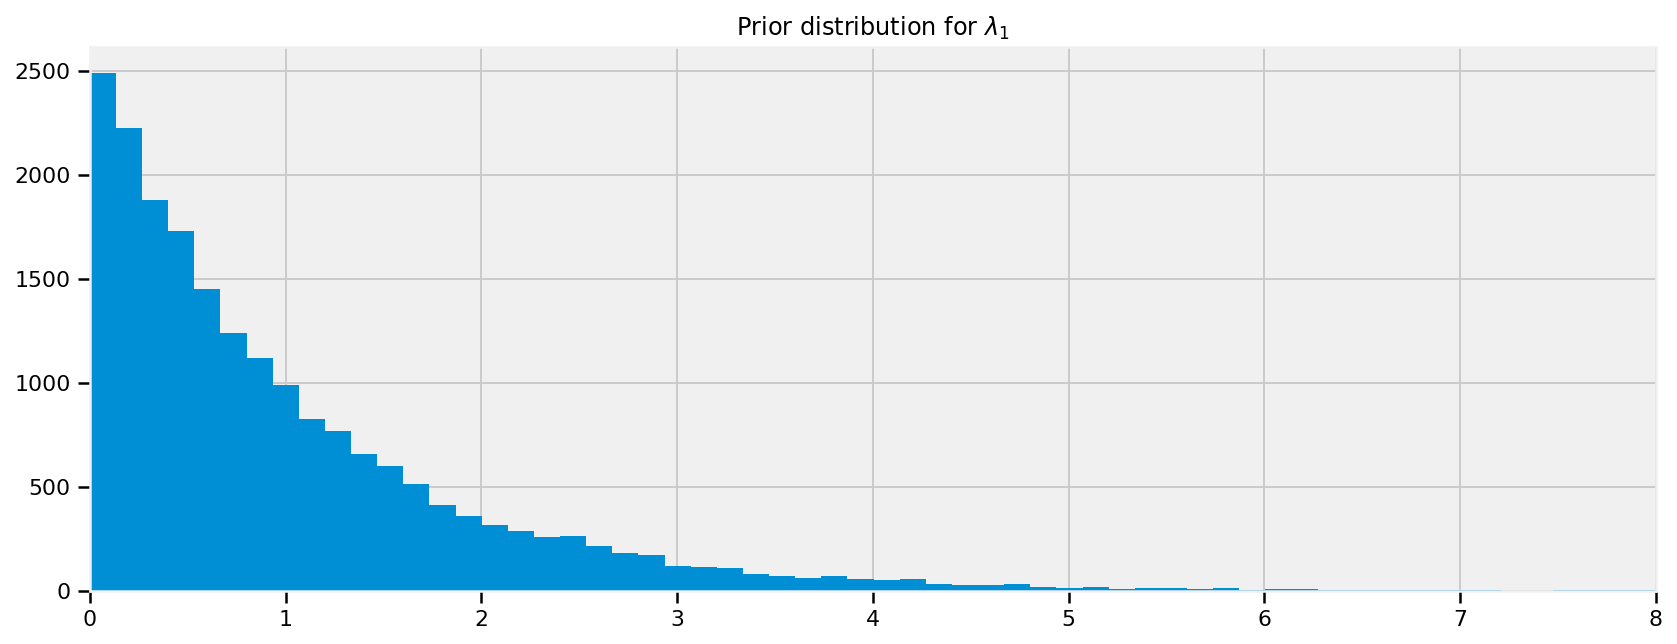

In [ ]:
# Define our observed samples
rv_λ_1 = Exponential(rate = 1.)
λ_1 = rv_λ_1.sample(sample_shape = 20000, seed = random.PRNGKey(0))
    
# Visualise stepwise prior distribution
plt.figure(figsize(12.5, 5))
plt.hist(λ_1, bins=70, histtype='stepfilled')
plt.title(r"Prior distribution for $\lambda_1$")
plt.xlim(0, 8);

To frame this in the notation of the first chapter, though this is a slight abuse of notation, we have specified $P(A)$. Our next goal is to include data/evidence/observations $X$ into our model. 

Sometimes we may want to match a property of our distribution to a property of observed data. To do so, we get the parameters for our distribution fom the data itself. In this example, the Poisson rate (average number of events) is explicitly set to one over the average of the data:

In [ ]:
data = np.array([10., 5.], dtype = f32)
rv_poisson = Poisson(rate = 1. / np.mean(data))
poisson = rv_poisson.sample(seed = random.PRNGKey(0))

print("Two predetermined data points:\n    ", data)
print("Mean of data:\n    ", np.mean(data))
print("Random sample from poisson distribution with the mean as the poisson's rate:\n    ", poisson)

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5770: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:3008: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "array")
/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:3114: UserW

Two predetermined data points:
     [10.  5.]
Mean of data:
     7.5
Random sample from poisson distribution with the mean as the poisson's rate:
     0.0


## Modeling approaches

A good starting thought to Bayesian modeling is to think about *how your data might have been generated*. Position yourself in an omniscient position, and try to imagine how *you* would recreate the dataset. 

In the last chapter we investigated text message data. We begin by asking how our observations may have been generated:

1.  We started by thinking "what is the best random variable to describe this count data?" A Poisson random variable is a good candidate because it can represent count data. So we model the number of sms's received as sampled from a Poisson distribution.

2.  Next, we think, "Ok, assuming sms's are Poisson-distributed, what do I need for the Poisson distribution?" Well, the Poisson distribution has a parameter $\lambda$. 

3.  Do we know $\lambda$? No. In fact, we have a suspicion that there are *two* $\lambda$ values, one for the earlier behaviour and one for the later behaviour. We don't know when the behaviour switches though, but call the switchpoint $\tau$.

4. What is a good distribution for the two $\lambda$s? The exponential is good, as it assigns probabilities to positive real numbers. Well the exponential distribution has a parameter too, call it $\alpha$.

5.  Do we know what the parameter $\alpha$ might be? No. At this point, we could continue and assign a distribution to $\alpha$, but it's better to stop once we reach a set level of ignorance: whereas we have a prior belief about $\lambda$, ("it probably changes over time", "it's likely between 10 and 30", etc.), we don't really have any strong beliefs about $\alpha$. So it's best to stop here. 

    What is a good value for $\alpha$ then? We think that the $\lambda$s are between 10-30, so if we set $\alpha$ really low (which corresponds to larger probability on high values) we are not reflecting our prior well. Similar, a too-high alpha misses our prior belief as well. A good idea for $\alpha$ as to reflect our belief is to set the value so that the mean of $\lambda$, given $\alpha$, is equal to our observed mean. This was shown in the last chapter.

6. We have no expert opinion of when $\tau$ might have occurred. So we will suppose $\tau$ is from a discrete uniform distribution over the entire timespan.


Below we give a graphical visualisation of this, where arrows denote `parent-child` relationships. (provided by the [Daft Python library](http://daft-pgm.org/) )

<img src="http://i.imgur.com/7J30oCG.png">


TFP and other probabilistic programming languages have been designed to tell these data-generation *stories*. More generally, B. Cronin writes [2]:

> Probabilistic programming will unlock narrative explanations of data, one of the holy grails of business analytics and the unsung hero of scientific persuasion. People think in terms of stories - thus the unreasonable power of the anecdote to drive decision-making, well-founded or not. But existing analytics largely fails to provide this kind of story; instead, numbers seemingly appear out of thin air, with little of the causal context that humans prefer when weighing their options.

### Same story; different ending.

Interestingly, we can create *new datasets* by retelling the story.
For example, if we reverse the above steps, we can simulate a possible realization of the dataset.

1\. Specify when the user's behaviour switches by sampling from $\text{DiscreteUniform}(0, 80)$:

In [ ]:
τ = random.uniform(shape = (1,), minval=0, maxval=80, key = random.PRNGKey(0))

print("Value of τ (randomly taken from DiscreteUniform(0, 80)):\n   ", τ)

Value of τ (randomly taken from DiscreteUniform(0, 80)):
    [33.476562]


2\. Draw $\lambda_1$ and $\lambda_2$ from a $\text{Gamma}(\alpha)$ distribution:

Note: A gamma distribution is a generalization of the exponential distribution. A gamma distribution with shape parameter $α = 1$ and scale parameter $β$ is an  exponential ($β$) distribution. Here, we use a gamma distribution to have more flexibility than we would have had were we to model with an exponential. Rather than returning values between $0$ and $1$, we can return values much larger than $1$ (i.e., the kinds of numbers one would expect to show up in a daily SMS count).

In [ ]:
alpha = 1. / 8.

λ_1, λ_2 = Gamma(concentration = 1 / alpha, rate = .3).sample(sample_shape = (2,), seed = random.PRNGKey(0))  
print("λ_1 (randomly taken from Gamma(α) distribution):\n   ", λ_1)
print("λ_2 (randomly taken from Gamma(α) distribution):\n   ", λ_2)

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5770: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:3008: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "array")
/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:3114: UserW

λ_1 (randomly taken from Gamma(α) distribution):
    22.106518
λ_2 (randomly taken from Gamma(α) distribution):
    17.642431


/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:3123: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in ones is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "ones")


3\.  For days before $\tau$, represent the user's received SMS count by sampling from $\text{Poisson}(\lambda_1)$, and sample from  $\text{Poisson}(\lambda_2)$ for days after $\tau$. For example:

In [ ]:
data = np.concatenate(
    [Poisson(rate = λ_1).sample(sample_shape = τ, seed = random.PRNGKey(0)),
     Poisson(rate = λ_2).sample(sample_shape = 80 - τ, seed = random.PRNGKey(0))],
    axis = 0)
days_range = np.arange(80)
print("Artificial day-by-day user SMS count created by sampling:\n   ", data)

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5770: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:3008: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "array")
/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:3114: UserW

Artificial day-by-day user SMS count created by sampling:
    [15. 17. 20. 23. 25. 28. 22. 23. 20. 20. 23. 26. 26. 26. 31. 26. 25. 18.
 23. 26. 20. 16. 25. 21. 14. 20. 23. 26. 22. 21. 15. 19. 30. 16. 24. 20.
 16.  8. 14. 18. 15. 16. 18. 17. 15. 20. 18. 18. 20. 18. 14. 11. 13. 26.
 16. 14. 17. 22. 20. 13. 16. 18. 17. 15. 30. 22. 19. 14. 22. 18. 13. 22.
 18. 21. 20. 19. 20. 18. 15.]


4\. Plot the artificial dataset:

ValueError: ignored

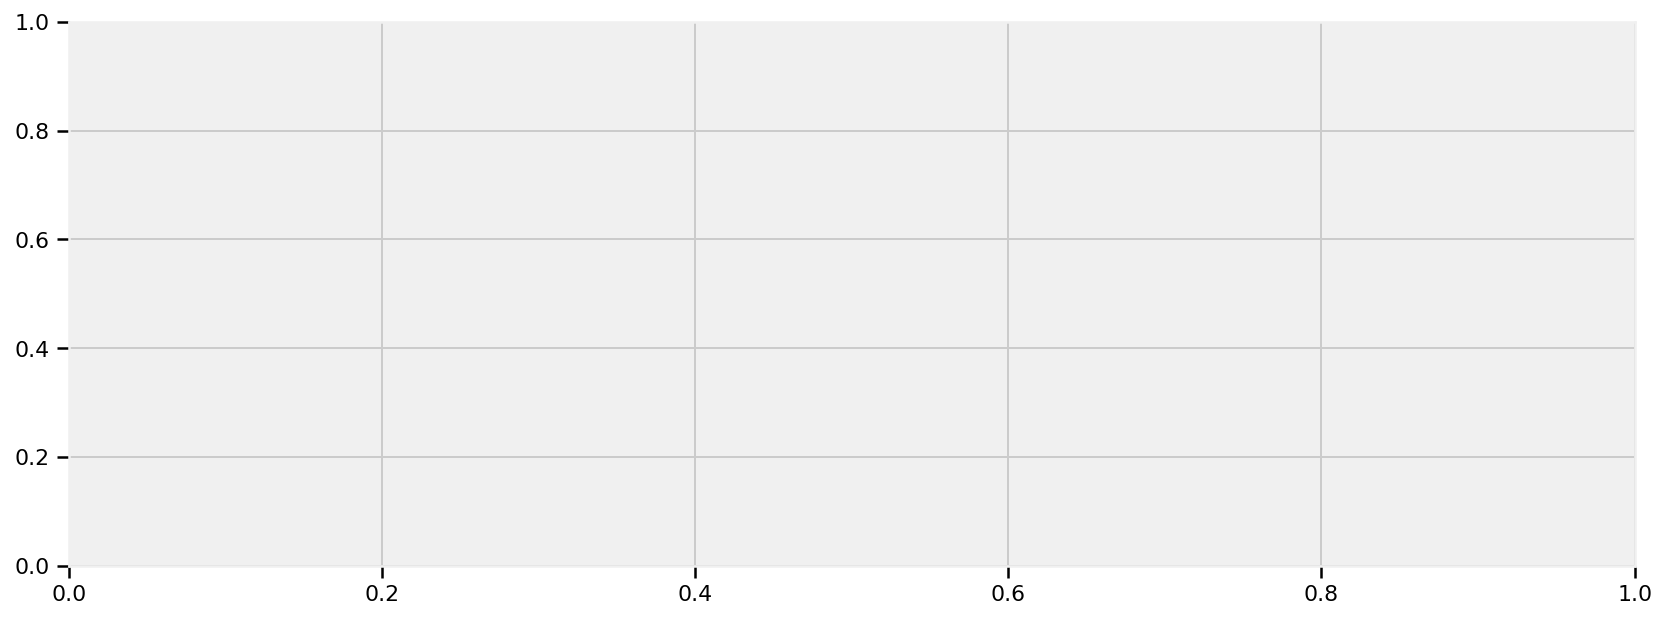

In [ ]:
plt.bar(days_range, data, color=TFColor[3])
plt.bar(τ - 1, data[int(τ) - 1], color='r', label="User behaviour changed")
plt.xlabel("Time (days)")
plt.ylabel("Count of text-msgs received")
plt.title("Artificial dataset")
plt.xlim(0, 80)
plt.legend();

It is okay that our fictional dataset does not look like our observed dataset: the probability is incredibly small it indeed would. TFP's engine is designed to find good parameters, $\lambda_i, \tau$, that maximise this probability.  


The ability to generate an artificial dataset is an interesting side effect of our modeling, and we will see that this ability is a very important method of Bayesian inference. We produce a few more datasets below:

In [ ]:
plt.figure(figsize(12.5, 8))
for i in range(4):
    plt.subplot(4, 1, i + 1)
    τ = random.uniform(shape = (1,), 
                       minval = 0, 
                       maxval = 80,
                       dtype = i32)
    alpha = 1. / 8.
    λ_1, λ_2 = Gamma(concentration = 1 / alpha, rate = 0.3).sample(sample_shape = (2,)) 
    data = np.concatenate([Poisson(rate = λ_1).sample(sample_shape = τ),
                           Poisson(rate = λ_2).sample(sample_shape = 80 - τ)],
                          axis = 0)
    days_range = np.arange(80)
    
    plt.bar(days_range, data, color=TFColor[3])
    plt.bar(τ - 1, data[int(τ) - 1], color='r', label="User behaviour changed")
    plt.xlim(0, 80)

Later we will see how we use this to make predictions and test the appropriateness of our models.

### Example: Bayesian A/B testing

A/B testing is a statistical design for determining the difference of effectiveness between two treatments. For example, a pharmaceutical company is interested in the effectiveness of drug A vs drug B. The company will test drug A on some fraction of their trials, and drug B on the other fraction (this fraction is often 1/2, but we will relax this assumption). After performing enough trials, the in-house statisticians sift through the data to determine which drug yielded better results. 

Similarly, front-end web developers are interested in which design of their website yields more sales or some other metric of interest. They will route some fraction of visitors to site A, and the other fraction to site B, and record if the visit yielded a sale or not. The data is recorded (in real-time), and analysed afterwards. 

Often, the post-experiment analysis is done using something called a hypothesis test like *difference of means test* or *difference of proportions test*. This involves often misunderstood quantities like a 'Z-score' and even more confusing 'p-values' (please don't ask). If you have taken a statistics course, you have probably been taught this technique (though not necessarily *learned* this technique). And if you were like me, you may have felt uncomfortable with their derivation -- good: the Bayesian approach to this problem is much more natural. 


### A Simple Case

As this is a hacker book, we'll continue with the web-dev example. For the moment, we will focus on the analysis of site A only. Assume that there is some true $0 \lt p_A \lt 1$ probability that users who, upon shown site A, eventually purchase from the site. This is the true effectiveness of site A. Currently, this quantity is unknown to us. 

Suppose site A was shown to $N$ people, and $n$ people purchased from the site. One might conclude hastily that $p_A = \frac{n}{N}$. Unfortunately, the *observed frequency* $\frac{n}{N}$ does not necessarily equal $p_A$ -- there is a difference between the *observed frequency* and the *true frequency* of an event. The true frequency can be interpreted as the probability of an event occurring. For example, the true frequency of rolling a 1 on a 6-sided die is $\frac{1}{6}$. Knowing the true frequency of events like:

- fraction of users who make purchases, 
- frequency of social attributes, 
- percent of internet users with cats etc. 

are common requests we ask of Nature. Unfortunately, often Nature hides the true frequency from us and we must *infer* it from observed data.

The *observed frequency* is then the frequency we observe: say rolling the die 100 times you may observe 20 rolls of 1. The observed frequency, 0.2, differs from the true frequency, $\frac{1}{6}$. We can use Bayesian statistics to infer probable values of the true frequency using an appropriate prior and observed data.


With respect to our A/B example, we are interested in using what we know, $N$ (the total trials administered) and $n$ (the number of conversions), to estimate what $p_A$, the true frequency of buyers, might be. 

To setup a Bayesian model, we need to assign prior distributions to our unknown quantities. *A priori*, what do we think $p_A$ might be? For this example, we have no strong conviction about $p_A$, so for now, let's assume $p_A$ is uniform over $[0,1]$:

In [ ]:
# The parameters are the bounds of the Uniform
rv_p = Uniform(low = 0., high = 1.)

Had we had stronger beliefs, we could have expressed them in the prior above.

For this example, consider $p_A = 0.05$, and $N = 1500$ users shown site A, and we will simulate whether the user made a purchase or not. To simulate this from $N$ trials, we will use a *Bernoulli* distribution: if  $X\ \sim \text{Ber}(p)$, then $X$ is 1 with probability $p$ and 0 with probability $1 - p$. Of course, in practice we do not know $p_A$, but we will use it here to simulate the data. We can assume then that we can use the following generative model:

$$\begin{align*}
p &\sim \text{Uniform}(\text{low}=0,\text{high}=1) \\
X\ &\sim \text{Bernoulli}(\text{prob}=p) \\
\text{for }  i &= 1\ldots N:\text{# Users}  \\
 X_i\ &\sim \text{Bernoulli}(p_i)
\end{align*}$$

In [ ]:
prob_true = .05  # This is unknown
N = 1500

# Sample N Bernoulli random variables from Ber(0.05).
# each random variable has a 0.05 chance of being a 1.
# this is the data-generation step

occurrences = Bernoulli(probs = prob_true).sample(sample_shape = N, seed = 10)
occurrences_sum = np.sum(occurrences)
occurrences_mean = np.mean(occurrences.astype(f32))

print(f"Array of {N} Occurences:", occurrences) 
# Remember Python treats True == 1, and False == 0
print("Sum of (True == 1) Occurences:", occurrences_sum)

The observed frequency is:

In [ ]:
# Occurrences.mean is equal to n / N
print(f"What is the observed frequency in Group A? {occurrences_mean:.4f}")
print(f"Does this equal the true frequency? {occurrences_mean == prob_true}")

We can combine our Bernoulli distribution and our observed occurrences into a log probability function based on the two.

In [ ]:
def joint_log_prob(occurrences, prob_A):
    """Joint log probability optimisation function.
        
    Args:
        occurrences: An array of binary values (0 or 1), representing 
            the observed frequency
        prob_A: scalar estimate of the probability of a 1 appearing 
    Returns: 
        sum of the joint log probabilities from all of the prior and conditional distributions
    """  
    rv_prob_A = Uniform(low = 0., high = 1.)
    rv_occurrences = Bernoulli(probs = prob_A)
    return (
          rv_prob_A.log_prob(prob_A)
        + np.sum(rv_occurrences.log_prob(occurrences)))

The goal of probabilistic inference is to find model parameters that may explain
data you have observed. TFP performs probabilistic inference by evaluating the
model parameters using a `joint_log_prob` function.  The arguments to `joint_log_prob` are data and model parameters—for the model defined in the `joint_log_prob` function itself. The function returns the log of the joint probability that the model parameterised as such generated the observed data per the input arguments.

All `joint_log_prob` functions have a common structure:

1. The function takes a set of **inputs** to evaluate. Each input is either an
observed value or a model parameter.

1. The `joint_log_prob` function uses probability distributions to define a **model** for evaluating the inputs. These distributions measure the likelihood of the input values. (By convention, the distribution which measures the likelihood of the variable `foo` will be named `rv_foo` to note that it is a random variable.) We use two types of distributions in `joint_log_prob` functions:

  a. **Prior distributions** measure the likelihood of input values.
A prior distribution never depends on an input value. Each prior distribution measures the
likelihood of a single input value. Each unknown variable—one that has not been
observed directly—needs a corresponding prior. Beliefs about which values could
be reasonable determine the prior distribution. Choosing a prior can be tricky,
so we will cover it in depth in Chapter 6.

  b. **Conditional distributions** measure the likelihood of an input value given
other input values. Typically, the conditional
distributions return the likelihood of observed data given the current guess of parameters in the model, p(observed_data | model_parameters).

1. Finally, we calculate and return the **joint log probability** of the inputs.
The joint log probability is the sum of the log probabilities from all of the
prior and conditional distributions. (We take the sum of log probabilities
instead of multiplying the probabilities directly for reasons of numerical
stability: floating point numbers in computers cannot represent the very small
values necessary to calculate the joint log probability unless they are in 
log space.) The sum of probabilities is actually an unnormalized density; although the total sum of probabilities  over all possible inputs might not sum to one, the sum of probabilities is proportional to the true probability density. This proportional distribution is sufficient to estimate the distribution of likely inputs.

Let's map these terms onto the code above. In this example, the input values
are the observed values in `occurrences` and the unknown value for `prob_A`. The `joint_log_prob` takes the current guess for `prob_A`
and answers, how likely is the data if `prob_A` is the probability of
`occurrences`. The answer depends on two distributions:
1. The prior distribution, `rv_prob_A`, indicates how likely the current value of `prob_A` is by itself.
2. The conditional distribution, `rv_occurrences`, indicates the likelihood of `occurrences` if `prob_A` were the  probability for the Bernoulli distribution.

The sum of the log of these probabilities is the
joint log probability. 

The `joint_log_prob` is particularly useful in conjunction with the [`tfp.mcmc`](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc)
module. Markov chain Monte Carlo (MCMC) algorithms proceed by making educated guesses about the unknown
input values and
computing what the likelihood of this set of arguments is. (We’ll talk about how it makes those guesses in Chapter 3.) By repeating this process
many times, MCMC builds a distribution of likely parameters. Constructing this
distribution is the goal of probabilistic inference.

Then we run our inference algorithm:

In [ ]:
num_results = 5000
num_burnin_steps = 1000
num_leapfrog_steps = 2

# Set the chain's start state
initial_chain_state = [
    np.mean(occurrences.astype(f32)) 
    * np.ones((), dtype = f32)]

# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfb.Identity()]  # Maps R -> R

# Define a closure over our joint_log_prob
# The closure makes it so the HMC doesn't try to change the `occurrences` but
# instead determines the distributions of other parameters that might generate
# the `occurrences` we observed.
unnormalised_posterior_log_prob = lambda *args: joint_log_prob(occurrences, *args)

# Initialise the step_size
step_size = tf.Variable(
    initial_value = tf.constant(.5, dtype = f32),
    trainable = False,
    name = 'step_size')

# Define the HMC
kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn = unnormalised_posterior_log_prob,
        num_leapfrog_steps = num_leapfrog_steps,
        step_size = step_size,
        state_gradients_are_stopped = True),
    bijector = unconstraining_bijectors)

kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel = kernel,
    num_adaptation_steps = int(num_burnin_steps * .8))

# Sample from the chain
(posterior_prob_A,), kernel_results = tfp.mcmc.sample_chain(
    num_results = num_results,
    num_burnin_steps = num_burnin_steps,
    current_state = initial_chain_state,
    kernel = kernel)

# print("Acceptance rate:", np.mean(kernel_results.inner_results.inner_results.is_accepted))

burned_prob_A_trace = posterior_prob_A[num_burnin_steps:]

We plot the posterior distribution of the unknown $p_A$ below:

In [ ]:
plt.figure(figsize(12.5, 4))
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(prob_true, 0, 90, linestyle='--', label="True $p_A$ (unknown)")
plt.hist(burned_prob_A_trace, bins=25, histtype='stepfilled')
plt.legend();

Our posterior distribution puts most weight near the true value of $p_A$, but also some weights in the tails. This is a measure of how uncertain we should be, given our observations. Try changing the number of observations, `N`, and observe how the posterior distribution changes.

### *A* and *B* Together

A similar analysis can be done for site B's response data to determine the analogous $p_B$. But what we are really interested in is the *difference* between $p_A$ and $p_B$. Let's infer $p_A$, $p_B$, *and* $\text{delta} = p_A - p_B$, all at once. We can do this using TFP's deterministic variables. (We'll assume for this exercise that $p_B = 0.04$, so $\text{delta} = 0.01$, $N_B = 750$ (significantly less than $N_A$) and we will simulate site B's data like we did for site A's data ). Our model now looks like the following:

$$\begin{align*}
p_A &\sim \text{Uniform}[\text{low}=0,\text{high}=1) \\
p_B &\sim \text{Uniform}[\text{low}=0,\text{high}=1) \\
X\ &\sim \text{Bernoulli}(\text{prob}=p) \\
\text{for }  i &= 1\ldots N: \\
 X_i\ &\sim \text{Bernoulli}(p_i)
\end{align*}$$

In [ ]:
# These two quantities are unknown to us
true_prob_A = .05
true_prob_B = .04

# Notice the unequal sample sizes -- no problem in Bayesian analysis
N_A = 1500
N_B = 750

# Generate some observations
observations_A = Bernoulli(probs = true_prob_A) \
    .sample(sample_shape = N_A, seed = 6.45)
observations_B = Bernoulli(probs = true_prob_B) \
    .sample(sample_shape = N_B, seed = 6.45)

print("Obs from Site A:", observations_A[:30], "...")
print("Observed Prob_A:", np.mean(observations_A), "...")
print("Obs from Site B:", observations_B[:30], "...")
print("Observed Prob_B:", np.mean(observations_B))

Below we run inference over the new model:

In [ ]:
def delta(prob_A, prob_B):
    """Defining the deterministic delta function. This is our unknown of interest.
        
    Args:
      prob_A: scalar estimate of the probability of a 1 appearing in 
                observation set A
      prob_B: scalar estimate of the probability of a 1 appearing in 
                observation set B
    Returns: 
      Difference between prob_A and prob_B
    """
    return prob_A - prob_B

  
def double_joint_log_prob(observations_A, observations_B, 
                          prob_A, prob_B):
    """
    Joint log probability optimisation function.
        
    Args:
      observations_A: An array of binary values representing the set of 
                      observations for site A
      observations_B: An array of binary values representing the set of 
                      observations for site B 
      prob_A: scalar estimate of the probability of a 1 appearing in 
                observation set A
      prob_B: scalar estimate of the probability of a 1 appearing in 
                observation set B 
    Returns: 
      Joint log probability optimisation function.
    """  
    rv_prob_A = Uniform(low = 0., high = 1.)
    rv_prob_B = Uniform(low = 0., high = 1.)
  
    rv_obs_A = Bernoulli(probs = prob_A)
    rv_obs_B = Bernoulli(probs = prob_B)
  
    return (
        rv_prob_A.log_prob(prob_A)
        + rv_prob_B.log_prob(prob_B)
        + tf.reduce_sum(rv_obs_A.log_prob(observations_A))
        + tf.reduce_sum(rv_obs_B.log_prob(observations_B)))

In [ ]:
num_results = 5000
num_burnin_steps = 1000
num_leapfrog_steps = 3

# Set the chain's start state
initial_chain_state = [    
    np.mean(observations_A.astype(f32)) * np.ones((), dtype = f32),
    np.mean(observations_B.astype(f32)) * np.ones((), dtype = f32)]

# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfb.Identity(),  # Maps R -> R
    tfb.Identity()]  # Maps R -> R

# Define a closure over our joint_log_prob
unnormalised_posterior_log_prob = lambda *args: double_joint_log_prob(observations_A, observations_B, *args)

# Initialise the step_size (it will be automatically adapted)
step_size = tf.Variable(
    initial_value = tf.constant(.5, dtype = f32),
    trainable = False,
    name = 'step_size')

# Define the HMC
kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn = unnormalised_posterior_log_prob,
        num_leapfrog_steps = 3,
        step_size = step_size,
        state_gradients_are_stopped = True),
    bijector = unconstraining_bijectors)

kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel = kernel,
    num_adaptation_steps = int(num_burnin_steps * .8))

# Sample from the chain
(posterior_prob_A, posterior_prob_B), kernel_results = tfp.mcmc.sample_chain(
    num_results = num_results,
    num_burnin_steps = num_burnin_steps,
    current_state = initial_chain_state,
    kernel = kernel)

#### Execute the TF graph to sample from the posterior

In [ ]:
# print("Acceptance rate:", np.mean(kernel_results.inner_results.inner_results.is_accepted))
burned_prob_A_trace = posterior_prob_A[num_burnin_steps:]
burned_prob_B_trace = posterior_prob_B[num_burnin_steps:]
burned_delta_trace = (posterior_prob_A - posterior_prob_B)[num_burnin_steps:]

Below we plot the posterior distributions for the three unknowns: 

In [ ]:
plt.figure(figsize(12.5, 12.5))

# Histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(burned_prob_A_trace, histtype='stepfilled', bins=25, alpha=.85,
         label="Posterior of $p_A$", color=TFColor[0])
plt.vlines(true_prob_A, 0, 80, linestyle='--', label="True $p_A$ (unknown)")
plt.legend(loc='upper right')
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(burned_prob_B_trace, histtype='stepfilled', bins=25, alpha=.85,
         label="Posterior of $p_B$", color=TFColor[2])
plt.vlines(true_prob_B, 0, 80, linestyle='--', label="True $p_B$ (unknown)")
plt.legend(loc='upper right')

ax = plt.subplot(313)
plt.hist(burned_delta_trace, histtype='stepfilled', bins=30, alpha=.85,
         label="Posterior of delta", color=TFColor[6])
plt.vlines(true_prob_A - true_prob_B, 0, 60, linestyle='--', label="True delta (unknown)")
plt.vlines(0, 0, 60, color='black', alpha=.2)
plt.legend(loc='upper right');

Notice that as a result of `N_B < N_A`, i.e. we have less data from site B, our posterior distribution of $p_B$ is fatter, implying we are less certain about the true value of $p_B$ than we are of $p_A$.  

With respect to the posterior distribution of $\text{delta}$, we can see that the majority of the distribution is above $\text{delta}=0$, implying there site A's response is likely better than site B's response. The probability this inference is incorrect is easily computable:

In [ ]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print(f"Probability site A is WORSE than site B: {np.mean(burned_delta_trace < 0):.3f}")
print(f"Probability site A is BETTER than site B: {np.mean(burned_delta_trace > 0):.3f}")

If this probability is too high for comfortable decision-making, we can perform more trials on site B (as site B has less samples to begin with, each additional data point for site B contributes more inferential "power" than each additional data point for site A). 

Try playing with the parameters `true_prob_A`, `true_prob_B`, `N_A`, and `N_B`, to see what the posterior of $\text{delta}$ looks like. Notice in all this, the difference in sample sizes between site A and site B was never mentioned: it naturally fits into Bayesian analysis.

I hope the readers feel this style of A/B testing is more natural than hypothesis testing, which has probably confused more than helped practitioners. Later in this book, we will see two extensions of this model: the first to help dynamically adjust for bad sites, and the second will improve the speed of this computation by reducing the analysis to a single equation.   

## An algorithm for human deceit

Social data has an additional layer of interest as people are not always honest with responses, which adds a further complication into inference. For example, simply asking individuals "Have you ever cheated on a test?" will surely contain some rate of dishonesty. What you can say for certain is that the true rate is less than your observed rate (assuming individuals lie *only* about *not cheating*; I cannot imagine one who would admit "Yes" to cheating when in fact they hadn't cheated). 

To present an elegant solution to circumventing this dishonesty problem, and to demonstrate Bayesian modeling, we first need to introduce the binomial distribution.


## The Binomial Distribution

The binomial distribution is one of the most popular distributions, mostly because of its simplicity and usefulness. Unlike the other distributions we have encountered thus far in the book, the binomial distribution has 2 parameters: $N$, a positive integer representing $N$ trials or number of instances of potential events, and $p$, the probability of an event occurring in a single trial. Like the Poisson distribution, it is a discrete distribution, but unlike the Poisson distribution, it only weighs integers from $0$ to $N$. The mass distribution looks like:

$$P( X = k ) =  {{N}\choose{k}}  p^k(1-p)^{N-k}$$

If $X$ is a binomial random variable with parameters $p$ and $N$, denoted $X \sim \text{Bin}(N,p)$, then $X$ is the number of events that occurred in the $N$ trials (obviously $0 \le X \le N$). The larger $p$ is (while still remaining between 0 and 1), the more events are likely to occur. The expected value of a binomial is equal to $Np$. Below we plot the mass probability distribution for varying parameters. 

In [ ]:
N = 10.
k_values = np.arange(start = 0, stop = N + 1, dtype = f32)
rv_probs_1 = Binomial(total_count = N, probs = .4).prob(k_values)
rv_probs_2 = Binomial(total_count = N, probs = .9).prob(k_values)

plt.figure(figsize=(12.5, 4))
colors = [TFColor[3], TFColor[0]] 

plt.bar(k_values - .5, rv_probs_1, color=colors[0],
        edgecolor=colors[0],
        alpha=.6,
        label=f"$N$: {10.}, $p$: {.4:.1f}",
        linewidth=3)
plt.bar(k_values - .5, rv_probs_2, color=colors[1],
        edgecolor=colors[1],
        alpha=.6,
        label=f"$N$: {10.}, $p$: {.9:.1f}",
        linewidth=3)

plt.legend(loc='upper left')
plt.xlim(0, 10.5)
plt.xlabel("$k$")
plt.ylabel("$P(X = k)$")
plt.title("Probability mass distributions of binomial random variables");

The special case when $N = 1$ corresponds to the Bernoulli distribution. There is another connection between Bernoulli and Binomial random variables. If we have $X_1, X_2, ... , X_N$ Bernoulli random variables with the same $p$, then $Z = X_1 + X_2 + ... + X_N \sim \text{Binomial}(N, p )$.

The expected value of a Bernoulli random variable is $p$. This can be seen by noting the more general Binomial random variable has expected value $Np$ and setting $N=1$.

## Example: Cheating among students

We will use the binomial distribution to determine the frequency of students cheating during an exam. If we let $N$ be the total number of students who took the exam, and assuming each student is interviewed post-exam (answering without consequence), we will receive integer $X$ "Yes I did cheat" answers. We then find the posterior distribution of $p$, given $N$, some specified prior on $p$, and observed data $X$. 

This is a completely absurd model. No student, even with a free-pass against punishment, would admit to cheating. What we need is a better *algorithm* to ask students if they had cheated. Ideally the algorithm should encourage individuals to be honest while preserving privacy. The following proposed algorithm is a solution I greatly admire for its ingenuity and effectiveness:

> In the interview process for each student, the student flips a coin, hidden from the interviewer. The student agrees to answer honestly if the coin comes up heads. Otherwise, if the coin comes up tails, the student (secretly) flips the coin again, and answers "Yes, I did cheat" if the coin flip lands heads, and "No, I did not cheat", if the coin flip lands tails. This way, the interviewer does not know if a "Yes" was the result of a guilty plea, or a Heads on a second coin toss. Thus privacy is preserved and the researchers receive honest answers. 

I call this the Privacy Algorithm. One could of course argue that the interviewers are still receiving false data since some *Yes*'s are not confessions but instead randomness, but an alternative perspective is that the researchers are discarding approximately half of their original dataset since half of the responses will be noise. But they have gained a systematic data generation process that can be modeled. Furthermore, they do not have to incorporate (perhaps somewhat naively) the possibility of deceitful answers. We can use TFP to dig through this noisy model, and find a posterior distribution for the true frequency of liars. 

Suppose 100 students are being surveyed for cheating, and we wish to find $p$, the proportion of cheaters. There are a few ways we can model this in TFP. I'll demonstrate the most explicit way, and later show a simplified version. Both versions arrive at the same inference. In our data-generation model, we sample $p$, the true proportion of cheaters, from a prior. Since we are quite ignorant about $p$, we will assign it a $\text{Uniform}(0,1)$ prior.

In [ ]:
N = 100
rv_p = Uniform(low = 0., high = 1.)

Again, thinking of our data-generation model, we assign Bernoulli random variables to the 100 students: 1 implies they cheated and 0 implies they did not. 

In [ ]:
N = 100
rv_p = Uniform(low = 0., high = 1.)
true_answers = Bernoulli(probs = rv_p.sample()).sample(sample_shape = N, seed = 5)

print(true_answers)
print(tf.reduce_sum(true_answers))

If we carry out the algorithm, the next step that occurs is the first coin-flip each student makes. This can be modeled again by sampling 100 Bernoulli random variables with $p=1/2$: denote a 1 as a *Heads* and 0 a *Tails*.

In [ ]:
N = 100
first_coin_flips = Bernoulli(probs = .5).sample(sample_shape = N, seed = 5)

print(first_coin_flips.numpy())

Although *not everyone* flips a second time, we can still model the possible realisation of second coin-flips:

In [ ]:
N = 100
second_coin_flips = Bernoulli(probs = .5).sample(sample_shape = N, seed = 5)

print(second_coin_flips)

Using these variables, we can return a possible realization of the *observed proportion* of "Yes" responses. 

In [ ]:
def observed_proportion_calc(t_a = true_answers, 
                             fc = first_coin_flips,
                             sc = second_coin_flips):
    """Unnormalised log posterior distribution function
        
    Args:
      t_a: array of binary variables representing the true answers
      fc: array of binary variables representing the simulated first flips 
      sc: array of binary variables representing the simulated second flips
    Returns: 
      Observed proportion of coin flips
    Closure over: N
    """
    observed = fc * t_a + (1 - fc) * sc
    observed_proportion = tf.cast(tf.reduce_sum(observed), f32) / tf.cast(N, f32)
    
    return tf.cast(observed_proportion, f32)

The line `fc*t_a + (1-fc)*sc` contains the heart of the Privacy algorithm. Elements in this array are 1 *if and only if* i) the first toss is heads and the student cheated or ii) the first toss is tails, and the second is heads, and are 0 else. Finally, the last line sums this vector and divides by `float(N)`, producing a proportion. 

In [ ]:
observed_proportion_val = observed_proportion_calc(t_a = true_answers,
                                                   fc = first_coin_flips,
                                                   sc = second_coin_flips)

print(observed_proportion_val)

Next we need a dataset. After performing our coin-flipped interviews the researchers received 35 "Yes" responses. To put this into a relative perspective, if there truly were no cheaters, we should expect to see on average 1/4 of all responses being a "Yes" (half chance of having first coin land Tails, and another half chance of having second coin land Heads), so about 25 responses in a cheat-free world. On the other hand, if *all students cheated*, we should expected to see approximately 3/4 of all responses be "Yes". 

The researchers observe a Binomial random variable, with `N = 100` and `total_yes = 35`:  

In [ ]:
total_count = 100
total_yes = 35

In [ ]:
def coin_joint_log_prob(total_yes, total_count, lies_prob):
    """Joint log probability optimization function.
      
    Args:
      headsflips: Integer for total number of observed heads flips
      N: Integer for number of total observation
      lies_prob: Test probability of a heads flip (1) for a Binomial distribution
    Returns: 
      Joint log probability optimization function.
    """
  
    rv_lies_prob = Uniform(low = 0., high = 1.)

    cheated = Bernoulli(probs = tf.cast(lies_prob, f32)).sample(total_count)
    first_flips = Bernoulli(probs = .5).sample(total_count)
    second_flips = Bernoulli(probs = .5).sample(total_count)
    observed_probability = tf.reduce_sum((
        cheated * first_flips + (1 - first_flips) * second_flips).astype(f32)) / total_count

    rv_yeses = Binomial(total_count = float(total_count),
                            probs = observed_probability)
    
    return (
        rv_lies_prob.log_prob(lies_prob)
        + tf.reduce_sum(rv_yeses.log_prob(tf.cast(total_yes, f32))))

Below we add all the variables of interest to our Metropolis-Hastings sampler and run our black-box algorithm over the model. It's important to note that we're using a Metropolis-Hastings MCMC instead of a Hamiltonian since we're sampling inside.

In [ ]:
num_steps = 5000
num_burnin_steps = 1000
total_count = 100

# Set the chain's start state.
initial_chain_state = [
    .4 * np.ones((), dtype = f32)]

# Define a closure over our joint_log_prob.
unnormalised_posterior_log_prob = lambda *args: coin_joint_log_prob(total_yes, total_count,  *args)

# Define the Metropolis-Hastings
# We use a Metropolis-Hastings method here instead of Hamiltonian method
# because the coin flips in the above example are non-differentiable and cannot
# be used with HMC
metropolis = tfp.mcmc.RandomWalkMetropolis(
    target_log_prob_fn = unnormalised_posterior_log_prob,
    seed = 54)

# Sample from the chain.
(posterior_p,), kernel_results = tfp.mcmc.sample_chain(
    num_results = num_results,
    num_burnin_steps = num_burnin_steps,
    current_state = initial_chain_state,
    kernel = metropolis,
    parallel_iterations = 1)

##### Executing the TF graph to sample from the posterior

In [ ]:
# This cell can take up to 5 minutes in Graph Mode
# print("Acceptance rate:", np.mean(kernel_results.inner_results.inner_results.is_accepted))
# print("prob_p trace:", posterior)
# print("prob_p burned trace:", posterior_p[num_burnin_steps:])
burned_cheating_freq_samples = posterior_p[num_burnin_steps:]

And finally we can plot the results.

In [ ]:
plt.figure(figsize(12.5, 6))
p_trace = burned_cheating_freq_samples
plt.hist(p_trace, histtype='stepfilled', density=True, alpha=.85, bins=30, 
         label="Posterior distribution", color=TFColor[3])
plt.vlines([.1, .40], [0, 0], [5, 5], alpha=.3)
plt.xlim(0, 1)
plt.legend();

With regards to the above plot, we are still pretty uncertain about what the true frequency of cheaters might be, but we have narrowed it down to a range between 0.1 to 0.4 (marked by the solid lines). This is pretty good, as *a priori* we had no idea how many students might have cheated (hence the uniform distribution for our prior). On the other hand, it is also pretty bad since there is a .3 length window the true value most likely lives in. Have we even gained anything, or are we still too uncertain about the true frequency? 

I would argue, yes, we have discovered something. It is implausible, according to our posterior, that there are *no cheaters*, i.e. the posterior assigns low probability to $p=0$. Since we started with an uniform prior, treating all values of $p$ as equally plausible, but the data ruled out $p=0$ as a possibility, we can be confident that there were cheaters. 

This kind of algorithm can be used to gather private information from users and be *reasonably* confident that the data, though noisy, is truthful. 



### Alternative TFP Model

Given a value for $p$ (which from our god-like position we know), we can find the probability the student will answer yes: 
$$
\begin{align}
P(\text{"Yes"}) &= P( \text{Heads on first coin} )P( \text{cheater} ) + P( \text{Tails on first coin} )P( \text{Heads on second coin} ) \\
&= \frac{1}{2}p + \frac{1}{2}\frac{1}{2}\\
&= \frac{p}{2} + \frac{1}{4}
\end{align}
$$
Thus, knowing $p$ we know the probability a student will respond "Yes". 

If we know the probability of respondents saying "Yes", which is `p_skewed`, and we have $N=100$ students, the number of "Yes" responses is a binomial random variable with parameters `N` and `p_skewed`.

This is where we include our observed 35 "Yes" responses out of a total of 100, which are then passed to the `joint_log_prob` in the code section further below, where we define our closure over the`joint_log_prob`.

In [ ]:
N = 100.
total_yes = 35.

def alt_joint_log_prob(yes_responses, N, prob_cheating):
    """
    Alternative joint log probability optimisation function.
        
    Args:
      yes_responses: Integer for total number of affirmative responses
      N: Integer for number of total observation
      prob_cheating: Test probability of a student actually cheating
    Returns: 
      Joint log probability optimisation function.
    """
    rv_prob = Uniform(low = 0., high = 1.)
    p_skewed = .5 * prob_cheating + .25
    rv_yes_responses = Binomial(total_count = tf.cast(N, f32), 
                                    probs = p_skewed)

    return (
        rv_prob.log_prob(prob_cheating)
        + tf.reduce_sum(rv_yes_responses.log_prob(tf.cast(yes_responses, f32)))
    )


Below we add all the variables of interest to our HMC component-defining cell and run our black-box algorithm over the model. 

In [ ]:
num_results = 5000
num_burnin_steps = 1000

# Set the chain's start state.
initial_chain_state = [
    .2 * np.ones((), dtype = f32)]

# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Sigmoid()]   # Maps [0,1] to R.

# Define a closure over our joint_log_prob.
# unnormalised_posterior_log_prob = lambda *args: alt_joint_log_prob(headsflips, total_yes, N, *args)
unnormalised_posterior_log_prob = lambda *args: alt_joint_log_prob(total_yes, N, *args)

# Initialise the step_size (it will be automatically adapted.)
step_size = tf.Variable(
    initial_value = tf.constant(.5, dtype = f32),
    trainable = False,
    name = 'skewed_step_size')

# Defining the HMC
kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn = unnormalised_posterior_log_prob,
        num_leapfrog_steps = 2,
        step_size = step_size,
        step_size_update_fn = tfp.mcmc.make_simple_step_size_update_policy(
            num_adaptation_steps = int(num_burnin_steps * .8)),
        state_gradients_are_stopped = True),
    bijector = unconstraining_bijectors)

# Sample from the chain
(posterior_skewed_p,), kernel_results = tfp.mcmc.sample_chain(
    num_results = num_results,
    num_burnin_steps = num_burnin_steps,
    current_state = initial_chain_state,
    kernel = kernel)

In [ ]:
# This cell may take 5 minutes in Graph Mode
# print("Acceptance rate:", np.mean(kernel_results.inner_results.inner_results.is_accepted))
# print("Final step size:", kernel_results.new_step_size[-100:].mean())

# print("p_skewed trace: ", posterior_skewed_p)
# print("p_skewed burned trace: ", posterior_skewed_p[num_burnin_steps:])
freq_cheating_samples = posterior_skewed_p[num_burnin_steps:]

Now we can plot our results

In [ ]:
plt.figure(figsize(12.5, 6))
p_trace = freq_cheating_samples
plt.hist(p_trace, histtype='stepfilled', alpha=.85, bins=30, 
         label="Posterior distribution", color=TFColor[3])
plt.vlines([.1, .40], [0, 0], [5, 5], alpha=.2)
plt.xlim(0, 1)
plt.legend();

The remainder of this chapter examines some practical examples of TFP and TFP modeling:

## Example: Challenger Space Shuttle Disaster <span id="challenger"/>

On January 28, 1986, the twenty-fifth flight of the U.S. space shuttle program ended in disaster when one of the rocket boosters of the Shuttle Challenger exploded shortly after lift-off, killing all seven crew members. The presidential commission on the accident concluded that it was caused by the failure of an O-ring in a field joint on the rocket booster, and that this failure was due to a faulty design that made the O-ring unacceptably sensitive to a number of factors including outside temperature. Of the previous 24 flights, data were available on failures of O-rings on 23, (one was lost at sea), and these data were discussed on the evening preceding the Challenger launch, but unfortunately only the data corresponding to the 7 flights on which there was a damage incident were considered important and these were thought to show no obvious trend. The data are shown below (see [1]):






In [ ]:
url = 'https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter2_MorePyMC/data/challenger_data.csv'
filename = wget.download(url)
filename

In [ ]:
plt.figure(figsize(12.5, 3.5))
np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt('challenger_data.csv', skip_header=1,
                                 usecols=[1, 2], missing_values='NA',
                                 delimiter=',')
# Drop the NA values
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

# Plot it, as a function of tempature (the first column)
print("Temp (F), O-Ring failure?")
print(challenger_data)

plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color='k',
            alpha=.5)
plt.yticks([0, 1])
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature");


It looks clear that *the probability* of damage incidents occurring increases as the outside temperature decreases. We are interested in modeling the probability here because it does not look like there is a strict cutoff point between temperature and a damage incident occurring. The best we can do is ask "At temperature $t$, what is the probability of a damage incident?". The goal of this example is to answer that question.

We need a function of temperature, call it $p(t)$, that is bounded between 0 and 1 (so as to model a probability) and changes from 1 to 0 as we increase temperature. There are actually many such functions, but the most popular choice is the *logistic function.*

$$p(t) = \frac{1}{ 1 + e^{ \;\beta t } } $$

In this model, $\beta$ is the variable we are uncertain about. Below is the function plotted for $\beta = 1, 3, -5$.

In [ ]:
def logistic(x, beta):
    return 1. / (1. + np.exp(beta * x))

x_vals = np.linspace(start = -4., stop = 4., num = 100)
log_beta_1 = logistic(x_vals, 1.)
log_beta_3 = logistic(x_vals, 3.)
log_beta_m5 = logistic(x_vals, -5.)

plt.figure(figsize(12.5, 3))
plt.plot(x_vals, log_beta_1, label=r"$\beta = 1$", color=TFColor[0])
plt.plot(x_vals, log_beta_3, label=r"$\beta = 3$", color=TFColor[3])
plt.plot(x_vals, log_beta_m5, label=r"$\beta = -5$", color=TFColor[6])
plt.legend();

But something is missing. In the plot of the logistic function, the probability changes only near zero, but in our data above the probability changes around 65 to 70. We need to add a *bias* term to our logistic function:

$$p(t) = \frac{1}{ 1 + e^{ \;\beta t + \alpha } } $$

Some plots are below, with differing $\alpha$.

In [ ]:
def logistic(x, beta, alpha=0):
    """Logistic Function with offset"""
    return 1. / (1. + np.exp((beta * x) + alpha))

x_vals = np.linspace(start = -4., stop = 4., num = 100)
log_beta_1_alpha_1 = logistic(x_vals, 1, 1)
log_beta_3_alpha_m2 = logistic(x_vals, 3, -2)
log_beta_m5_alpha_7 = logistic(x_vals, -5, 7)

plt.figure(figsize(12.5, 3))
plt.plot(x_vals, log_beta_1, label=r"$\beta = 1$", ls='--', lw=1, color=TFColor[0])
plt.plot(x_vals, log_beta_3, label=r"$\beta = 3$", ls='--', lw=1, color=TFColor[3])
plt.plot(x_vals, log_beta_m5, label=r"$\beta = -5$", ls='--', lw=1, color=TFColor[6])
plt.plot(x_vals, log_beta_1_alpha_1, label=r"$\beta = 1, \alpha = 1$", color=TFColor[0])
plt.plot(x_vals, log_beta_3_alpha_m2, label=r"$\beta = 3, \alpha = -2$", color=TFColor[3])
plt.plot(x_vals, log_beta_m5_alpha_7, label=r"$\beta = -5, \alpha = 7$", color=TFColor[6])
plt.legend(loc='lower left');

Adding a constant term $\alpha$ amounts to shifting the curve left or right (hence why it is called a *bias*).

Let's start modeling this in TFP. The $\beta, \alpha$ parameters have no reason to be positive, bounded or relatively large, so they are best modeled by a *Normal random variable*, introduced next.

### Normal distributions

A Normal random variable, denoted $X \sim N(\mu, 1/\tau)$, has a distribution with two parameters: the mean, $\mu$, and the *precision*, $\tau$. Those familiar with the Normal distribution already have probably seen $\sigma^2$ instead of $\tau^{-1}$. They are in fact reciprocals of each other. The change was motivated by simpler mathematical analysis and is an artifact of older Bayesian methods. Just remember: the smaller $\tau$, the larger the spread of the distribution (i.e. we are more uncertain); the larger $\tau$, the tighter the distribution (i.e. we are more certain). Regardless, $\tau$ is always positive. 

The probability density function of a $N( \mu, 1/\tau)$ random variable is:

$$ f(x | \mu, \tau) = \sqrt{\frac{\tau}{2\pi}} \exp\left( -\frac{\tau}{2} (x-\mu)^2 \right) $$

We plot some different density functions below. 

In [ ]:
rand_x_vals = np.linspace(start = -8., stop = 7., num = 150)

density_func_1 = Normal(loc = -2., scale = 1. / .7).prob(rand_x_vals)
density_func_2 = Normal(loc = 0., scale = 1. / 1).prob(rand_x_vals)
density_func_3 = Normal(loc = 3., scale = 1. / 2.8).prob(rand_x_vals)

colors = [TFColor[3], TFColor[0], TFColor[6]]

plt.figure(figsize(12.5, 3))
plt.plot(rand_x_vals, density_func_1,
         label=fr'$\mu = {-2.}, \tau = {.7:.1f}$', color=TFColor[3])
plt.fill_between(rand_x_vals, density_func_1, color=TFColor[3], alpha=.33)
plt.plot(rand_x_vals, density_func_2, 
         label=r"$\mu = %d, \tau = %.1f$" % (0., 1), color=TFColor[0])
plt.fill_between(rand_x_vals, density_func_2, color=TFColor[0], alpha=.33)
plt.plot(rand_x_vals, density_func_3,
         label=r"$\mu = %d, \tau = %.1f$" % (3., 2.8), color=TFColor[6])
plt.fill_between(rand_x_vals, density_func_3, color=TFColor[6], alpha=.33)

plt.legend(loc=r'upper right')
plt.xlabel(r"$x$")
plt.ylabel(r"Density function at $x$")
plt.title(r"Probability distribution of three different Normal random variables");

A Normal random variable can be take on any real number, but the variable is very likely to be relatively close to $\mu$. In fact, the expected value of a Normal is equal to its $\mu$ parameter:

$$ E[ X | \mu, \tau] = \mu$$

and its variance is equal to the inverse of $\tau$:

$$\text{Var}( X | \mu, \tau ) = \frac{1}{\tau}$$



Below we continue our modeling of the Challenger space craft:

In [ ]:
temperature = challenger_data[:, 0]
temperature = tf.convert_to_tensor(temperature, dtype = f32)
D = challenger_data[:, 1]  # Defect or not?
D = tf.convert_to_tensor(D, dtype = f32)

beta = Normal(loc = .3, scale = 1000.).sample()
alpha = Normal(loc = -15., scale = 1000.).sample()
p_deterministic = tfd.Deterministic(loc = 1. / (1. + np.exp(beta * temperature + alpha))).sample()

We have our probabilities, but how do we connect them to our observed data? A *Bernoulli* random variable with parameter $p$, denoted $\text{Bernoulli}(p)$, is a random variable that takes value 1 with probability $p$, and 0 else. Thus, our model can look like:

$$ \text{Defect Incident, }D_i \sim \text{Bernoulli}( p(t_i) ), \;\; i=1..N$$

where $p(t)$ is our logistic function and $t_i$ are the temperatures we have observations about. Notice in the code below we set the values of `beta` and `alpha` to 0 in `initial_chain_state`. The reason for this is that if `beta` and `alpha` are very large, they make `p` equal to 1 or 0. Unfortunately, `Bernoulli` does not like probabilities of exactly 0 or 1, though they are mathematically well-defined probabilities. So, by setting the coefficient values to `0`, we set the variable `p` to be a reasonable starting value. This has no effect on our results, nor does it mean we are including any additional information in our prior. It is simply a computational caveat in TFP. 

In [ ]:
def challenger_joint_log_prob(D, temperature, alpha, beta):
    """Joint log probability optimization function.
        
    Args:
      D: The Data from the challenger disaster representing presence or 
         absence of defect
      temperature_: The Data from the challenger disaster, specifically the temperature on 
         the days of the observation of the presence or absence of a defect
      alpha: one of the inputs of the HMC
      beta: one of the inputs of the HMC
    Returns: 
      Joint log probability optimization function.
    """
    rv_alpha = Normal(loc = 0., scale = 1000.)
    rv_beta = Normal(loc = 0., scale = 1000.)

    # Make this into a logit
    logistic_p = 1. / (1. + np.exp(beta * tf.cast(temperature, f32) + alpha))
    rv_observed = Bernoulli(probs = logistic_p)
    
    return (
        rv_alpha.log_prob(alpha)
        + rv_beta.log_prob(beta)
        + tf.reduce_sum(rv_observed.log_prob(D)))

In [ ]:
num_results = 5000
num_burnin_steps = 1000

# Set the chain's start state.
initial_chain_state = [
    0. * np.ones((), dtype = f32),
    0. * np.ones((), dtype = f32)]

# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
# Alpha is 100x of beta approximately, so apply Affine scalar bijector
# to multiply the unconstrained alpha by 100 to get back to 
# the Challenger problem space
unconstraining_bijectors = [
    tfb.AffineScalar(100.),
    tfb.Identity()]

# Define a closure over our joint_log_prob.
unnormalised_posterior_log_prob = lambda *args: challenger_joint_log_prob(D, temperature, *args)

# Initialise the step_size. (It will be automatically adapted.)
step_size = tf.Variable(
    initial_value = tf.constant(.01, dtype = f32),
    trainable = False,
    name = 'step_size')

# Define the HMC
kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn = unnormalised_posterior_log_prob,
        num_leapfrog_steps = 40,  # To improve convergence
        step_size = step_size,
        state_gradients_are_stopped = True),
    bijector = unconstraining_bijectors)

kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel = kernel,
    num_adaptation_steps = int(num_burnin_steps * .8))

# Sample from the chain
(posterior_alpha, posterior_beta), kernel_results = tfp.mcmc.sample_chain(
    num_results = num_results,
    num_burnin_steps = num_burnin_steps,
    current_state = initial_chain_state,
    kernel = kernel)

# print("Acceptance rate:", np.mean(kernel_results.inner_results.inner_results.is_accepted))
# print("Final step size:", kernel_results.new_step_size[-100:].mean())

We have trained our model on the observed data, so lets look at the posterior distributions for $\alpha$ and $\beta$:

In [ ]:
plt.figure(figsize(12.5, 6))
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(posterior_beta, histtype='stepfilled', bins=35, alpha=.85,
         label=r"Posterior of $\beta$", color=TFColor[6], density=True)
plt.legend()
plt.subplot(212)
plt.hist(posterior_alpha, histtype='stepfilled', bins=35, alpha=.85,
         label=r"Posterior of $\alpha$", color=TFColor[0], density=True)
plt.legend();

All samples of $\beta$ are greater than 0. If instead the posterior was centered around 0, we may suspect that $\beta = 0$, implying that temperature has no effect on the probability of defect. 

Similarly, all $\alpha$ posterior values are negative and far away from 0, implying that it is correct to believe that $\alpha$ is significantly less than 0. 

Regarding the spread of the data, we are very uncertain about what the true parameters might be (though considering the low sample size and the large overlap of defects-to-nondefects this behaviour is perhaps expected).  

Next, let's look at the *expected probability* for a specific value of the temperature. That is, we average over all samples from the posterior to get a likely value for $p(t_i)$.

In [ ]:
alpha_samples_1d = posterior_alpha[:, None]  # Best to make them 1d
beta_samples_1d = posterior_beta[:, None]

beta_mean = np.mean(np.transpose(beta_samples_1d)[0])
alpha_mean = np.mean(np.transpose(alpha_samples_1d)[0])

print("beta mean:", beta_mean)
print("alpha mean:", alpha_mean)

def logistic(x, beta, alpha=0):
    """Logistic function with alpha and beta."""
    return 1. / (1. + np.exp((beta * x) + alpha))

t = np.linspace(start = tf.reduce_min(temperature) - 5,
                stop = tf.reduce_max(temperature) + 5,
                num = 2500)[:, None]
p_t = logistic(np.transpose(t), beta_samples_1d, alpha_samples_1d)
mean_prob_t = logistic(np.transpose(t), beta_mean, alpha_mean)

In [ ]:
plt.figure(figsize(12.5, 3))
plt.plot(t, np.transpose(mean_prob_t), lw=3, label="Average posterior \nprobability of defect")
plt.plot(t, np.transpose(p_t)[:, 0], ls='--', label="Realization from posterior")
plt.plot(t, np.transpose(p_t)[:, -8], ls='--', label="Realization from posterior")
plt.scatter(temperature, D, color='k', s=50, alpha=.5)
plt.title("Posterior expected value of probability of defect; plus realizations")
plt.legend(loc='lower left')
plt.ylim(-.1, 1.1)
plt.xlim(tf.reduce_min(t), tf.reduce_max(t))
plt.ylabel("Probability")
plt.xlabel("Temperature");

Above we also plotted two possible realizations of what the actual underlying system might be. Both are equally likely as any other draw. The blue line is what occurs when we average all the 20000 possible dotted lines together.


In [ ]:
from scipy.stats.mstats import mquantiles

# Vectorised bottom and top 2.5% quantiles for "confidence interval"
qs = mquantiles(p_t, [.025, .975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=.7, color='#7A68A6')
plt.plot(t[:, 0], qs[0], label="95% CI", color='#7A68A6', alpha=.7)
plt.plot(t[:, 0], mean_prob_t[0, :], lw=1, ls='--', color='k',
         label="Average posterior \nprobability of defect")
plt.xlim(tf.reduce_min(t), tf.reduce_max(t))
plt.ylim(-.02, 1.02)
plt.legend(loc='lower left')
plt.scatter(temperature, D, color='k', s=50, alpha=.5)
plt.xlabel("Temp, $t$")
plt.ylabel("Probability estimate")
plt.title("Posterior probability estimates given temp. $t$");

The 95% credible interval, or 95% CI, painted in purple, represents the interval, for each temperature, that contains 95% of the distribution. For example, at 65 degrees, we can be 95% sure that the probability of defect lies between 0.25 and 0.85.

More generally, we can see that as the temperature nears 60 degrees, the CI's spread out over $[0,1]$ quickly. As we pass 70 degrees, the CI's tighten again. This can give us insight about how to proceed next: we should probably test more O-rings around 60-65 temperature to get a better estimate of probabilities in that range. Similarly, when reporting to scientists your estimates, you should be very cautious about simply telling them the expected probability, as we can see this does not reflect how *wide* the posterior distribution is.

### What about the day of the Challenger disaster?

On the day of the Challenger disaster, the outside temperature was 31 degrees Fahrenheit. What is the posterior distribution of a defect occurring,  given this temperature? The distribution is plotted below. It looks almost guaranteed that the Challenger was going to be subject to defective O-rings.

In [ ]:
plt.figure(figsize(12.5, 3))
prob_31 = logistic(31, posterior_beta, posterior_alpha)
plt.xlim(.98, 1)
plt.hist(prob_31, bins=10, density=True, histtype='stepfilled')
plt.title("Posterior distribution of probability of defect, given $t = 31$")
plt.xlabel("probability of defect occurring in O-ring");

### Is our model appropriate?

The skeptical reader will say "You deliberately chose the logistic function for $p(t)$ and the specific priors. Perhaps other functions or priors will give different results. How do I know I have chosen a good model?" This is absolutely true. To consider an extreme situation, what if I had chosen the function $p(t) = 1,\; \forall t$, which guarantees a defect always occurring: I would have again predicted disaster on January 28th. Yet this is clearly a poorly chosen model. On the other hand, if I did choose the logistic function for $p(t)$, but specified all my priors to be very tight around 0, likely we would have very different posterior distributions. How do we know our model is an expression of the data? This encourages us to measure the model's **goodness of fit**.

We can think: *how can we test whether our model is a bad fit?* An idea is to compare observed data with artificial dataset which we can simulate. The rationale is that if the simulated dataset does not appear similar, statistically, to the observed dataset, then likely our model is not accurately represented the observed data. 

Previously in this Chapter, we simulated an artificial dataset for the SMS example. To do this, we sampled values from the priors. We saw how varied the resulting datasets looked like, and rarely did they mimic our observed dataset. In the current example,  we should sample from the *posterior* distributions to create *very plausible datasets*. Luckily, our Bayesian framework makes this very easy. We only need to gather samples from the distribution of choice, and specify the number of samples, the shape of the samples (we had 21 observations in our original dataset, so we'll make the shape of each sample 21), and the probability we want to use to determine the ratio of 1 observations to 0 observations.


Hence we create the following:

```python
simulated_data = Bernoulli(probs = p).sample(sample_shape = (N,))
```
Let's simulate 10,000:

In [ ]:
alpha = alpha_mean  # Basing these values on the outputs of the model above
beta = beta_mean
p_deterministic = tfd.Deterministic(
    loc = 1. / (1. + np.exp(beta * temperature + alpha))).sample()  # seed=6.45
simulated_data = Bernoulli(probs = p_deterministic).sample(sample_shape = (10000,))

simulations = simulated_data
print("Number of simulations:            ", simulations.shape[0])
print("Number data points per simulation:", simulations.shape[1])

plt.figure(figsize(12.5, 12))
plt.title("Simulated dataset using posterior parameters")
for i in range(4):
    ax = plt.subplot(4, 1, i + 1)
    plt.scatter(temperature, simulations[1000 * i, :], color='k',
                s=50, alpha=.6)

Note that the above plots are different (if you can think of a cleaner way to present this, please send a pull request and answer [here](http://stats.stackexchange.com/questions/53078/how-to-visualize-bayesian-goodness-of-fit-for-logistic-regression)!).

We wish to assess how good our model is. 'Good' is a subjective term of course, so results must be relative to other models. 

We will be doing this graphically as well, which may seem like an even less objective method. The alternative is to use *Bayesian p-values*. These are still subjective, as the proper cutoff between good and bad is arbitrary. Gelman emphasises that the graphical tests are more illuminating [3] than p-value tests. We agree.

The following graphical test is a novel data-viz approach to logistic regression. The plots are called *separation plots*[4]. For a suite of models we wish to compare, each model is plotted on an individual separation plot. I leave most of the technical details about separation plots to the very accessible [original paper](http://mdwardlab.com/sites/default/files/GreenhillWardSacks.pdf), but I'll summarise their use here.

For each model, we calculate the proportion of times the posterior simulation proposed a value of 1 for a particular temperature, i.e. compute $P( \;\text{Defect} = 1 | t, \alpha, \beta )$ by averaging. This gives us the posterior probability of a defect at each data point in our dataset. For example, for the model we used above:

In [ ]:
posterior_probability = np.mean(simulations, axis = 0)
print("Posterior prob of defect | Realized defect ")
for i in range(len(D)):
    print("%.2f                     |   %d" % (posterior_probability[i], D[i]))

Next we sort each column by the posterior probabilities:

In [ ]:
ix = np.argsort(posterior_probability)
print("probb | defect ")
for i in range(len(D)):
    print("%.2f  |   %d" % (posterior_probability[ix[i]], D[ix[i]]))

We can present the above data better in a figure: we've created a `separation_plot` function.

In [ ]:
 def separation_plot(p, y, **kwargs):
    """This function creates a separation plot for logistic and probit classification. 
    See http://mdwardlab.com/sites/default/files/GreenhillWardSacks.pdf
    
    p: tf.Tensor, the proportions/probabilities, can be a nxM matrix which represents M models.
    y: tf.Tensor, the 0-1 response variables.
    """    
    assert p.shape[0] == y.shape[0]
    n = p.shape[0]

    if len(p.shape) > 1:
        m = p.shape[1]
    else:
        p = tf.reshape(p, (n, 1))
        m = p.shape[1]

    colors = ['#EEE', '#348ABD']

    fig = plt.figure()
    
    for i in range(m):
        ax = fig.add_subplot(m, 1, i + 1)
        ix = np.argsort(p[:, i])
        # Plot the different bars
        bars = ax.bar(np.arange(n), np.ones(n), width=1.,
                      color=colors[i%2],  # colors_bmh[ y[ix].astype(int) ]
                      edgecolor='none')
        ax.plot(np.arange(n + 1), np.append(p[ix, i], p[ix, i][-1]), 'k',
                linewidth=1., drawstyle='steps-post')
        # Create expected value bar.
        ax.vlines([tf.reduce_sum((1 - p[ix, i]))], [0], [1])
        plt.xlim(0, n)
        
    plt.tight_layout()
    return

plt.figure(figsize(11., 3))
separation_plot(posterior_probability, D)

In [ ]:
# TODO Check those types
posterior_probability, D  # tf.Tensor(shape=(23,), dtype=int32), f.Tensor(shape=(23,), dtype=float32)

The snaking-line is the sorted probabilities, blue bars denote defects, and empty space (or grey bars for the optimistic readers) denote non-defects. As the probability rises, we see more and more defects occur. On the right hand side, the plot suggests that as the posterior probability is large (line close to 1), then more defects are realised. This is good behaviour. Ideally, all the blue bars *should* be close to the right-hand side, and deviations from this reflect missed predictions. 

The black vertical line is the expected number of defects we should observe, given this model. This allows the user to see how the total number of events predicted by the model compares to the actual number of events in the data.

It is much more informative to compare this to separation plots for other models. Below we compare our model (top) versus three others:

1. the perfect model, which predicts the posterior probability to be equal 1 if a defect did occur.
2. a completely random model, which predicts random probabilities regardless of temperature.
3. a constant model:  where $P(D = 1 \; | \; t) = c, \;\; \forall t$. The best choice for $c$ is the observed frequency of defects, in this case 7/23.  


In [ ]:
plt.figure(figsize(11., 2))

# Our temperature-dependent model
separation_plot(posterior_probability, D)
plt.title("Temperature-dependent model")

# Perfect model
# i.e. the probability of defect is equal to if a defect occurred or not.
p = D
separation_plot(p, D)
plt.title("Perfect model")

# Random predictions
p = np.random.rand(23)
separation_plot(p, D)
plt.title("Random model")

# Constant model
constant_prob = 7. / 23 * np.ones(23)
separation_plot(constant_prob, D)
plt.title("Constant-prediction model");

In the random model, we can see that as the probability increases there is no clustering of defects to the right-hand side. Similarly for the constant model.

In the perfect model, the probability line is not well shown, as it is stuck to the bottom and top of the figure. Of course the perfect model is only for demonstration, and we cannot infer any scientific inference from it.

## Exercises

1\. Try putting in extreme values for our observations in the cheating example. What happens if we observe 25 affirmative responses? 10? 50? 

In [ ]:
# type your code here

2\. Try plotting $\alpha$ samples versus $\beta$ samples.  Why might the resulting plot look like this?

In [ ]:
# type your code here
plt.figure(figsize(12.5, 4))

plt.scatter(alpha, beta, alpha=.1)
plt.title("Why does the plot look like this?")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$");

## References

[1] Dalal, Fowlkes and Hoadley (1989),JASA, 84, 945-957.

[2] Cronin, Beau. "Why Probabilistic Programming Matters." 24 Mar 2013. Google, Online Posting to Google . Web. 24 Mar. 2013. <https://plus.google.com/u/0/+BeauCronin/posts/KpeRdJKR6Z1>.

[3] Gelman, Andrew. "Philosophy and the practice of Bayesian statistics." British Journal of Mathematical and Statistical Psychology. (2012): n. page. Web. 2 Apr. 2013.

[4] Greenhill, Brian, Michael D. Ward, and Audrey Sacks. "The Separation Plot: A New Visual Method for Evaluating the Fit of Binary Models." American Journal of Political Science. 55.No.4 (2011): n. page. Web. 2 Apr. 2013.
